## Install dependencies

In [1]:
#!pip install git+https://github.com/jthermiz/nma_timely_tigers --quiet
from nma_timely_tigers import utils, models
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd

In [2]:
from importlib import reload
reload(utils)

<module 'nma_timely_tigers.utils' from '/home/jhermiz/projects/nma_timely_tigers/nma_timely_tigers/utils.py'>

In [3]:
%matplotlib inline

## Load dataset

In [4]:
alldat = utils.load_steinmetz_dataset() # note this takes a bit bc it downloads data

Loading data from disk


## Fixed parameters

In [9]:
p = {}
#p['areas'] = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
p['areas'] = ["VISp"]
p['start_time'] = 0.5
p['end_time'] = 1.2
p['optimizer'] = torch.optim.Adam
p['epochs'] = 2000
p['early_stop_count'] = 200
p['exp_name'] = 'all_session_visp'

## Sweeping parameter(s)

In [10]:
s = {}
s['hidden_units'] = [100]

## Main loop

0
using GPU
On epoch 0 of 2000
Train accuracy: 34.228
Validation accuracy: 33.846

Early stopped at 430
Finished training!


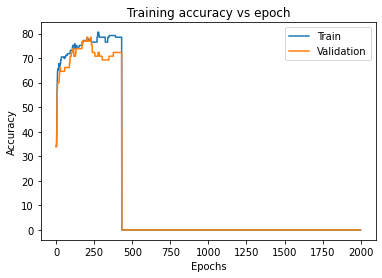

using GPU
On epoch 0 of 2000
Train accuracy: 34.228
Validation accuracy: 33.846



In [ ]:
results = []
for session, dat in enumerate(alldat[:]):
    print(session)
    for param in s['hidden_units']:      
        for stim in [False, True]:
            for shuf in [False, True]:
                spks, _ = utils.get_neurons_by_brain_area(dat, areas=p['areas'])                 
                
                y = dat['response'] + 1 
                if stim:
                    y = utils.stimulus_labels(dat)
                
                X = utils.average_trials_across_time(spks, 
                                                    start_time=p['start_time'],
                                                    end_time=p['end_time'],
                                                    fs=100).T                
                
                if shuf:
                    X = utils.shuffle_neurons(X, y)

                # must have >10 neurons
                if X.shape[1] > 10:
                    net = models.TwoLayer(D_in=X.shape[1], H=param, D_out=3)
                    acc_df, last_epoch = utils.train(net, X, y, 
                                         epochs=p['epochs'],
                                         optimizer=torch.optim.Adam(net.parameters()),
                                         early_stop_count=p['early_stop_count'])  
                    result = {'session': session, list(s.keys())[0]: param, 
                              'shuffle': shuf, 'stimulus_decode': stim,
                              'accuracy_epoch': acc_df, 
                              'test_accuracy':acc_df.values[last_epoch,1]}
                    results.append(result)
                    fig, ax = utils.plot_accuracy(acc_df)
                    #plt.savefig('test.png', dpi=300)

## Save data to disk

In [ ]:
results_df = pd.DataFrame(results)
results_df.head()

In [ ]:
results_df.to_pickle(p['exp_name'] + '_results' + '.pkl')
pd.DataFrame(p).loc[0].to_pickle(p['exp_name'] + '_parameters' + '.pkl')
!ls

## Post hoc analysis

In [ ]:
# for idx, row in results_df.iterrows():
#     mask = row['accuracy_epoch']['Train'] > 0
#     tmp = row['accuracy_epoch'][mask]
#     results_df['test_accuracy'][idx] = tmp.values[-1, 1]

# results_df['test_accuracy'].head()

In [ ]:
results_df.head()

In [ ]:
for stim in [False, True]:
    tmp = results_df[results_df['stimulus_decode'] == stim]
    no_shuf = tmp['test_accuracy'][::2]
    shuf = tmp['test_accuracy'][1::2]
    sns.scatterplot(no_shuf.values, shuf.values)    
    plt.xlabel('No shuffle accuracy')
    plt.ylabel('Shuffle accuracy')
plt.legend(['Behavior', 'Stimulus'])
plt.plot([0, 100], [0, 100], 'k--')

In [ ]:
tmp = results_df[results_df['stimulus_decode'] == False]
stats = tmp.groupby('shuffle').agg(['describe'])['test_accuracy']
stats

In [ ]:
tmp = results_df[results_df['stimulus_decode'] == True]
stats = tmp.groupby('shuffle').agg(['describe'])['test_accuracy']
stats